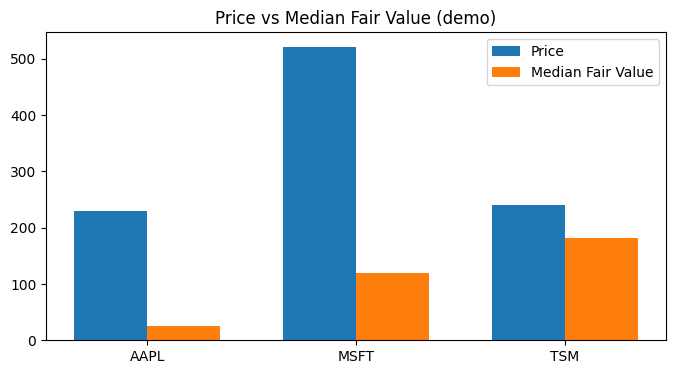

In [ ]:
import json, os, math, datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

BASE = os.path.abspath(".")
CONFIG_PATH = os.path.join(BASE, "config.json")
TICKERS_PATH = os.path.join(BASE, "tickers.txt")
OUTPUT_DIR = os.path.join(BASE, "output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    CFG = json.load(f)
with open(TICKERS_PATH, "r", encoding="utf-8") as f:
    TICKERS = [t.strip() for t in f if t.strip()]

CFG, TICKERS


def safe_get(dic, *keys, default=None):
    cur = dic
    try:
        for k in keys:
            if cur is None: 
                return default
            cur = cur[k]
        return cur if cur is not None else default
    except Exception:
        return default

def get_quote_and_info(ticker):
    t = yf.Ticker(ticker)
    info = getattr(t, "info", {}) or {}
    hist = t.history(period="1y")
    price = None
    if not hist.empty:
        price = float(hist["Close"].iloc[-1])
    else:
        price = info.get("currentPrice") or info.get("regularMarketPrice")
    return price, info, t


# 3.1 DCF
def dcf_value_from_yf(ticker, discount_rate=None, terminal_growth=None, years=5):
    discount_rate = discount_rate or CFG["discount_rate"]
    terminal_growth = terminal_growth or CFG["terminal_growth"]
    t = yf.Ticker(ticker)
    try:
        cf = t.cashflow
        cfo = safe_get(cf, "Total Cash From Operating Activities")
        capex = safe_get(cf, "Capital Expenditures")
        if cfo is None or capex is None:
            return None
        fcf_series = (cfo - capex).dropna().astype(float)
        if fcf_series.empty:
            return None
        fcf0 = float(fcf_series.iloc[0])
    except Exception:
        return None

    vals = [(fcf0 * ((1 + terminal_growth) ** i)) / ((1 + discount_rate) ** i) for i in range(1, years+1)]
    fcf_T = fcf0 * ((1 + terminal_growth) ** years)
    terminal = (fcf_T * (1 + terminal_growth)) / (discount_rate - terminal_growth)
    pv_terminal = terminal / ((1 + discount_rate) ** years)
    return sum(vals) + pv_terminal


# 3.2 DDM
def ddm_two_stage_auto(ticker, years1=5, payout_ratio=None, g_long=None, discount_rate=None):
    payout_ratio = payout_ratio or CFG["ddm_defaults"]["payout_ratio"]
    g_long = g_long or CFG["ddm_defaults"]["long_run_growth"]
    discount_rate = discount_rate or CFG["discount_rate"]

    t = yf.Ticker(ticker)
    info = getattr(t, "info", {}) or {}
    dividends = t.dividends
    if dividends is not None and not dividends.empty:
        d0 = float(dividends[-4:].sum())
    else:
        eps = info.get("trailingEps")
        d0 = (payout_ratio * eps) if eps else None

    if not d0 or d0 <= 0 or g_long >= discount_rate:
        return None

    pv = sum([(d0 * ((1 + g_long) ** i)) / ((1 + discount_rate) ** i) for i in range(1, years1+1)])
    d_next = d0 * ((1 + g_long) ** (years1 + 1))
    terminal = d_next / (discount_rate - g_long)
    pv_terminal = terminal / ((1 + discount_rate) ** years1)

    return pv + pv_terminal


# 3.3 Graham Number
def graham_number(eps, bvps):
    try:
        return math.sqrt(22.5 * float(eps) * float(bvps))
    except Exception:
        return None

# 3.4 Buffett Approximation
def buffett_style_price(eps, growth_pct):
    try:
        return float(eps) * (8.5 + 2.0 * float(growth_pct))
    except Exception:
        return None



# 4. run the values
def run_for_ticker(ticker):
    price, info, t = get_quote_and_info(ticker)
    dcf_firm = dcf_value_from_yf(ticker)
    shares = info.get("sharesOutstanding") or None
    dcf_ps = (dcf_firm / shares) if (dcf_firm and shares and shares > 0) else None

    ddm_val = ddm_two_stage_auto(ticker)
    eps = info.get("trailingEps")
    bvps = info.get("bookValue")
    graham_val = graham_number(eps, bvps)
    growth5y = info.get("earningsQuarterlyGrowth") or info.get("earningsGrowth") or 0.08
    buffett_val = buffett_style_price(eps, growth5y*100.0) if eps else None

    return {
        "Ticker": ticker,
        "Price": price,
        "DCF_ps": dcf_ps,
        "DDM": ddm_val,
        "Graham": graham_val,
        "BuffettApprox": buffett_val
    }

results = [run_for_ticker(t) for t in TICKERS]
df = pd.DataFrame(results)
df

# 5. saving
ts = dt.datetime.utcnow().strftime("%Y-%m-%d %H:%M UTC")
df_out = df.copy()
df_out["AsOf"] = ts
csv_path = os.path.join(OUTPUT_DIR, "results.csv")
df_out.to_csv(csv_path, index=False)
csv_path


# 6. charts
model_cols = ["DCF_ps", "DDM", "Graham", "BuffettApprox"]
df["FairValueMedian"] = df[model_cols].median(axis=1, skipna=True)

plt.figure(figsize=(8,4))
x = np.arange(len(df))
width = 0.35
plt.bar(x - width/2, df["Price"].values, width, label="Price")
plt.bar(x + width/2, df["FairValueMedian"].values, width, label="Median Fair Value")
plt.xticks(x, df["Ticker"].tolist())
plt.title("Price vs Median Fair Value (demo)")
plt.legend()
plt.show()